# Initial data exploration

In [2]:
# The data should be downloaded, use 1.0-download-raw-data.ipynb notebook
raw_data_path = '../data/raw/filtered.tsv'

### Read data to pandas DataFrame

In [3]:
import pandas as pd


df = pd.read_csv(raw_data_path, sep='\t', index_col=0)
df.head()

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
0,"If Alkar is flooding her with psychic waste, t...","if Alkar floods her with her mental waste, it ...",0.785171,0.010309,0.014195,0.981983
1,Now you're getting nasty.,you're becoming disgusting.,0.749687,0.071429,0.065473,0.999039
2,"Well, we could spare your life, for one.","well, we can spare your life.",0.919051,0.268293,0.213313,0.985068
3,"Ah! Monkey, you've got to snap out of it.","monkey, you have to wake up.",0.664333,0.309524,0.053362,0.994215
4,I've got orders to put her down.,I have orders to kill her.,0.726639,0.181818,0.009402,0.999348


### Insights about data

There are English data sample pairs <`text with high toxicity level`, `paraphrased text with low toxicity level`>. I will repeat for conveniece the description of the data columns below.

| Column | Type | Discription | 
| ----- | ------- | ---------- |
| reference | str | First item from the pair | 
| ref_tox | float | toxicity level of reference text | 
| translation | str | Second item from the pair - paraphrazed version of the reference|
| trn_tox | float | toxicity level of translation text |
| similarity | float | cosine similarity of the texts |
| length_diff | float | relative length difference between texts |

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 577777 entries, 0 to 577776
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   reference    577777 non-null  object 
 1   translation  577777 non-null  object 
 2   similarity   577777 non-null  float64
 3   lenght_diff  577777 non-null  float64
 4   ref_tox      577777 non-null  float64
 5   trn_tox      577777 non-null  float64
dtypes: float64(4), object(2)
memory usage: 30.9+ MB


In [5]:
df.describe()

,similarity,lenght_diff,ref_tox,trn_tox
count,577777.000000,577777.000000,577777.000000,577777.000000
mean,0.758469,0.157652,0.541372,0.434490
std,0.092695,0.108057,0.457571,0.458904
min,0.600001,0.000000,0.000033,0.000033
25%,0.681105,0.066667,0.012171,0.000707
50%,0.754439,0.141791,0.806795,0.085133
75%,0.831244,0.238095,0.990469,0.973739
max,0.950000,0.400000,0.999724,0.999730


In [11]:
# Understanding relative length difference feature
import numpy as np


sample = df.iloc[0]
print(sample)
length_diff = abs(1 - len(sample['translation']) / len(sample['reference']))
len(sample['reference']), len(sample['translation']), length_diff, np.isclose(length_diff, sample['lenght_diff'], 1e-1)

reference      If Alkar is flooding her with psychic waste, t...
translation    if Alkar floods her with her mental waste, it ...
similarity                                              0.785171
lenght_diff                                             0.010309
ref_tox                                                 0.014195
trn_tox                                                 0.981983
Name: 0, dtype: object


(95, 96, 0.010526315789473717, True)

According to pandas `describe()` and given paper [[1]](../references/1-text-detox-filtered-paranmnt-paper.pdf): 

- To make the text more manageable for the model to process, we need to split `reference` and `translation` into smaller units called tokens (i.e., do tokenization step). It is worth noticing that some of `reference` text are actually have low toxicity level and `translation` text have high toxicity level, which contradicts with dataset description, so we need take it into account.
    - Below, I plotted pairs (`ref_tox`, `trn_tox`) sorted increasingly by to see their disctibution. This plot proves that there are exists pairs with inverted toxicities (almost half of the dataset).
    - Also, values around 0.5 might confuse the model, maybe we can filter them, but I am not sure that it will give much performance. There are calculations of number of such values below.
- Toxicity level of reference and translation can be used as a numerical feature for the model. This level ranges between 0 and 1, where a value closer to 1 indicates more toxicity, and closer to 0 means less toxicity.
- Similarity is computed as the cosine distance between the averaged BERT embeddings of all words in a sentence of the text. Similarity values fall between 0.6 and 0.95. Higher similarity values mean the texts are more alike, and when the similarity is 1, it means the texts are exactly the same. Can be used as a numerical feature for the model.
- Relative length difference between text computed as a ratio between character length of reference and character length of translation. The maximum difference is 40%, and it can be used as a numerical feature for the model.

In [15]:
import matplotlib.pyplot as plt


sorted_toxicities = sorted(list(zip(list(df['ref_tox']), list(df['trn_tox']))), key=lambda x: x[0])
indexes = list(range(len(sorted_toxicities)))

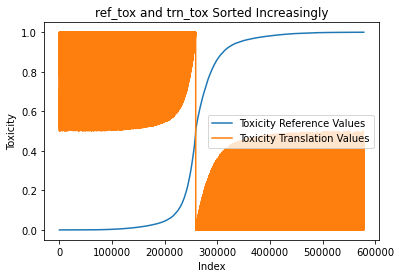

In [17]:
plt.plot(indexes, sorted_toxicities, label=('Toxicity Reference Values', 'Toxicity Translation Values'))
plt.xlabel('Index')
plt.ylabel('Toxicity')
plt.title('ref_tox and trn_tox Sorted Increasingly')
plt.legend()
plt.show()

In [22]:
import numpy as np


proximity_threshold = 1e-1

ref_tox_close_to_0_5 = np.sum(np.isclose(df['ref_tox'], 0.5, atol=proximity_threshold))
trn_tox_close_to_0_5 = np.sum(np.isclose(df['trn_tox'], 0.5, atol=proximity_threshold))

print(f'ref_tox values close to 0.5: {ref_tox_close_to_0_5}')
print(f'trn_tox values close to 0.5: {trn_tox_close_to_0_5}')
print(f'Total values close to 0.5: {ref_tox_close_to_0_5 + trn_tox_close_to_0_5}')

ref_tox values close to 0.5: 10486
trn_tox values close to 0.5: 9789
Total values close to 0.5: 20275


For the first try, we can start by creating a dictionary-based model that leverages the vocabulary from the provided dataset to replace highly toxic words. 

Next, we can combine all the numerical features with text representation embeddings. Custom embeddings could include all data features: `similarity`, `length_diff`, `ref_tox`, `reference`, `trn_tox`, and `translation`. To keep these elements organized, we can include separator tokens between the text embeddings and numerical features. This approach is applicable to various sequence-to-sequence models, such as RNNs, LSTMs, GRUs, or Transformers. According to [[2]](../references/2-attention-is-all-you-need-paper.pdf), attention mechanism is all we need, so most probably I will only experiment with Transformer-based models, such as BERT, CondBERT. Most probably, it will be a baseline.

Additionally, we can explore utilizing a pretrained Large Language Model (LLM) like GPT or Llama. Different techniques, such as zero-shot, few-shot, or in-context learning, can be applied to fine-tune the model for the task.

In summary, we can pursue three main avenues for experimentation:
1. dictionary-based approach
2. Transformer-based models
3. pretrained LLMs